Simulated BGS galaxy spectra are generated using dark and bright sky spectrum then 
run through the `redrock` pipeline in order to measure redshifts. 



In [ ]:
import os
import numpy as np 
# -- astropy --
from astropy.io import fits
from desispec.io import read_spectra
from desispec.io import write_spectra
from desispec.spectra import Spectra
# -- local --
from feasibgs import util as UT
from feasibgs import catalogs as Cat
from feasibgs import forwardmodel as FM

In [2]:
import corner as DFM

import matplotlib as mpl 
import matplotlib.pyplot as pl 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

Read in Gama-Legacy catalog G09 field

In [3]:
field = 'g15'
cata = Cat.GamaLegacy()
gleg = cata.Read(field)
if field == 'g09': 
    nblocks = 26
elif field == 'g15': 
    nblocks = 64

properties of the GAMA-Legacy survey 

In [6]:
redshift = gleg['gama-spec']['z']
ngal = len(redshift)
print('%i galaxies in the GAMA-Legacy %s region' % (ngal, field.upper()))

63004 galaxies in the GAMA-Legacy G15 region


In [5]:
# apparent magnitudes from Legacy photometry
g_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_g'])#, method='log')
r_mag_legacy = UT.flux2mag(gleg['legacy-photo']['flux_r'])#, method='log')
# apparent magnitude from Legacy photometry aperture flux
g_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_g'][:,1])
r_mag_legacy_apflux = UT.flux2mag(gleg['legacy-photo']['apflux_r'][:,1])
# apparent magnitude from GAMA photometry
g_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_g'])
r_mag_gama = UT.flux2mag(gleg['gama-photo']['modelmag_r'])
# H-alpha line flux from GAMA spectroscopy
gama_ha = gleg['gama-spec']['ha_flux']

# absolute magnitude calculated using GAMA photometry
absmag_ugriz = cata.AbsMag(gleg, kcorr=0.1, H0=70, Om0=0.3)
g_absmag_gama = absmag_ugriz[1,:]
r_absmag_gama = absmag_ugriz[2,:]

In [7]:
print('%i galaxies do not have Halpha line flux' % np.sum(gama_ha <= 0.))

21420 galaxies do not have Halpha line flux


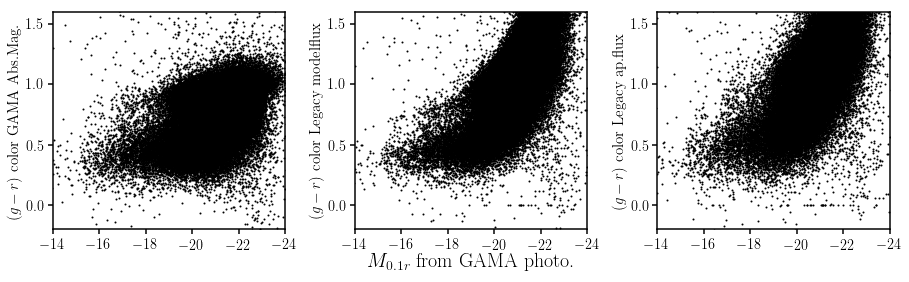

In [8]:
fig = plt.figure(figsize=(15, 4))
ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, y, ylbl in zip(range(1,4), ys, ylbls):
    sub = fig.add_subplot(1,3,i)
    sub.scatter(r_absmag_gama, y, c='k', s=1.)
    if i == 2: sub.set_xlabel('$M_{0.1r}$ from GAMA photo.', fontsize=20)
    sub.set_xlim([-14., -24])
    sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
    sub.set_ylim([-0.2, 1.6])
fig.subplots_adjust(wspace=0.3)

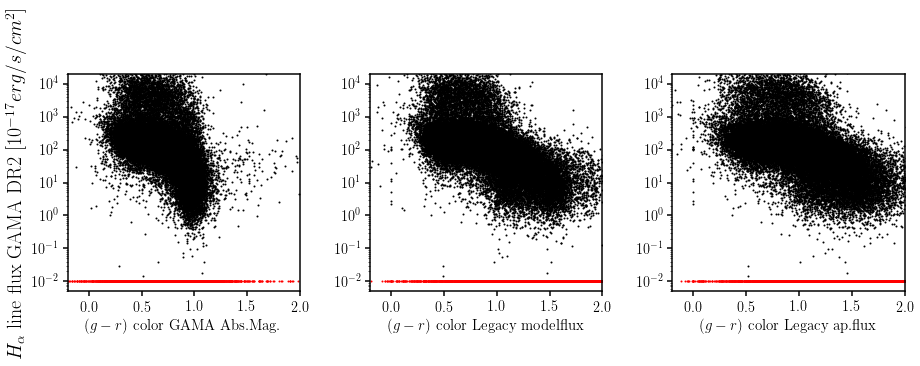

In [9]:
fig = plt.figure(figsize=(15, 4))
xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
    sub = fig.add_subplot(1, len(xs), i)
    hasha = (gama_ha > 0.)
    sub.scatter(x[hasha], gama_ha[hasha], s=1, c='k')
    sub.scatter(x[np.invert(hasha)], np.repeat(1e-2, np.sum(np.invert(hasha))), s=1, c='r')
    sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
    sub.set_xlim([-0.2, 2.])
    if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([5e-3, 2e4])
    sub.set_yscale('log')
fig.subplots_adjust(wspace=0.3)

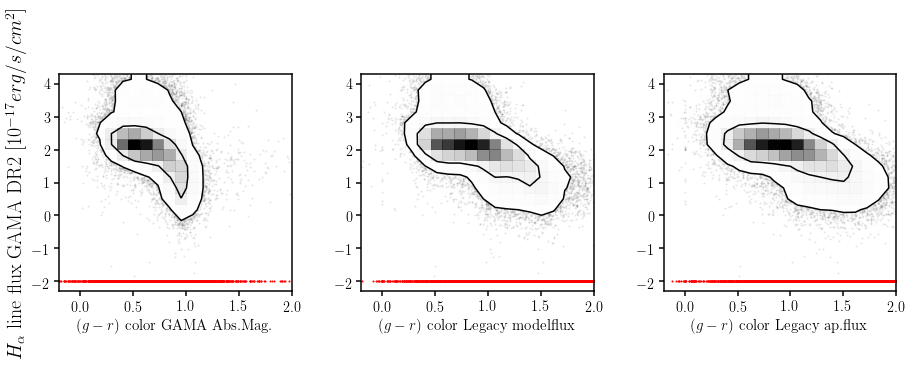

In [10]:
fig = plt.figure(figsize=(15, 4))
xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
    sub = fig.add_subplot(1, len(xs), i)
    hasha = (gama_ha > 0.)
    #sub.scatter(x[hasha], np.log10(gama_ha[hasha]), s=1, c='k')
    DFM.hist2d(x[hasha], np.log10(gama_ha[hasha]), color='k', 
               levels=[0.68, 0.95], range=[[-0.2, 2.], [np.log10(5e-3), np.log10(2e4)]], 
               plot_datapoints=True, fill_contours=False, plot_density=True, ax=sub) 
    sub.scatter(x[np.invert(hasha)], np.repeat(-2, np.sum(np.invert(hasha))), s=1, c='r')
    sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
    sub.set_xlim([-0.2, 2.])
    if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([np.log10(5e-3), np.log10(2e4)])
    #sub.set_yscale('log')
fig.subplots_adjust(wspace=0.3)

Read in the `redrock` redshift measurements for a subsample of the simulated spectra 

In [11]:
dir_redrock = ''.join([UT.dat_dir(), 'redrock/'])
dir_spectra = ''.join([UT.dat_dir(), 'spectra/'])
i_block = 5

f_z_dark = ''.join([dir_redrock, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.fits'])
zdark_data = fits.open(f_z_dark)[1].data

f_i_dark = ''.join([dir_spectra, 
                    'GamaLegacy.', field, '.expSpectra.darksky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.index'])
i_dark = np.loadtxt(f_i_dark, unpack=True, usecols=[0], dtype='i')

f_z_bright = ''.join([dir_redrock, 
                      'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.redrock.fits'])
zbright_data = fits.open(f_z_bright)[1].data

f_i_bright = ''.join([dir_spectra, 
                      'GamaLegacy.', field, '.expSpectra.brightsky.seed1.exptime300.', str(i_block), 'of', str(nblocks), 'blocks.index'])
i_bright = np.loadtxt(f_i_bright, unpack=True, usecols=[0], dtype='i')


In [12]:
print('%i redshifts' % len(zdark_data['Z']))

1000 redshifts


In [13]:
assert np.array_equal(i_dark, i_bright)

In [14]:
z_gama = redshift[i_dark]

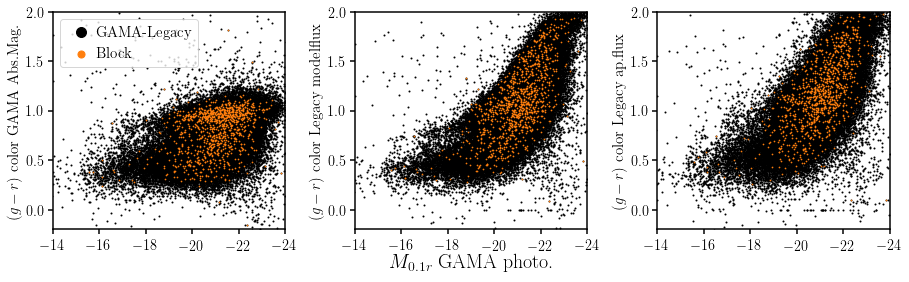

In [15]:
fig = plt.figure(figsize=(15, 4))
ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, y, ylbl in zip(range(1,4), ys, ylbls):
    sub = fig.add_subplot(1,3,i)
    sub.scatter(r_absmag_gama, y, c='k', s=1., label='GAMA-Legacy')
    sub.scatter(r_absmag_gama[i_dark], y[i_dark], c='C1', s=0.5, label='Block')
    if i == 2: sub.set_xlabel('$M_{0.1r}$ GAMA photo.', fontsize=20)
    sub.set_xlim([-14., -24])
    sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
    sub.set_ylim([-0.2, 2.])
    if i == 1: sub.legend(loc="upper left", markerscale=10, handletextpad=0., frameon=True, prop={'size':15})
fig.subplots_adjust(wspace=0.3)

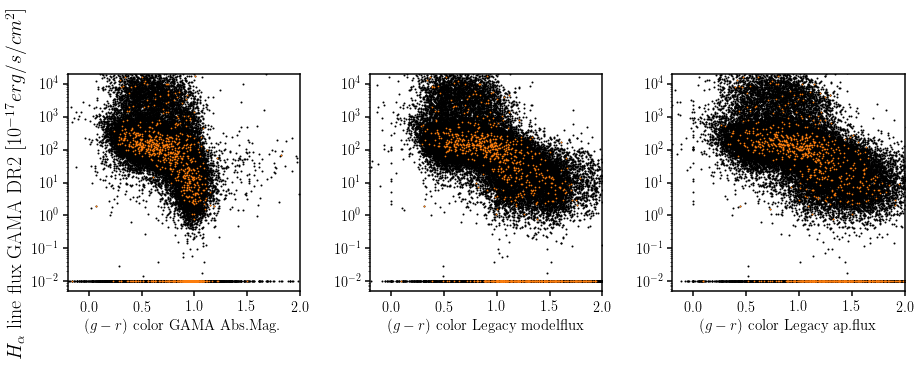

In [16]:
fig = plt.figure(figsize=(15, 4))
xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
    sub = fig.add_subplot(1, len(xs), i)
    hasha = (gama_ha > 0)
    sub.scatter(x[hasha], gama_ha[hasha], s=1, c='k', label='GAMA-Legacy')
    sub.scatter(x[np.invert(hasha)], np.repeat(1e-2, np.sum(np.invert(hasha))), s=1, c='k')
    
    inblock = np.zeros(ngal, dtype=bool)
    inblock[i_dark] = True
    sub.scatter(x[inblock & hasha], gama_ha[inblock & hasha], c='C1', s=0.5, label='Block')
    sub.scatter(x[inblock & np.invert(hasha)], np.repeat(1e-2, np.sum(inblock & np.invert(hasha))), c='C1', s=0.5)
    sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
    sub.set_xlim([-0.2, 2.])
    if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([5e-3, 2e4])
    sub.set_yscale('log')
fig.subplots_adjust(wspace=0.3)

A number of galaxies do not have significant flux within the fiber aperture. 
This would complicate things since the spectra are flux calibrated to reproduce
the aperture flux photometry. So lets impose a cut to remove these galaxies.

In [17]:
mag_cut = (gleg['legacy-photo']['apflux_r'][:,1] > 0.)
print('--------------------------------------------')
print('out of the entire GLEG catalog')
print('%f remain after mag cut' % (float(np.sum(mag_cut))/float(ngal)))
print('%i galaxies remaining' % np.sum(mag_cut))
print('--------------------------------------------')
print('out of the block')
print('%f remain after mag cut' % (float(np.sum(mag_cut & inblock))/float(np.sum(inblock))))
print('%i galaxies remaining' % np.sum(mag_cut & inblock))

--------------------------------------------
out of the entire GLEG catalog
0.998698 remain after mag cut
62922 galaxies remaining
--------------------------------------------
out of the block
0.998000 remain after mag cut
998 galaxies remaining


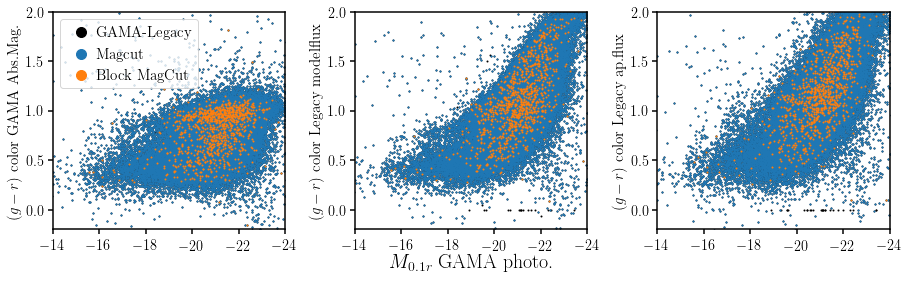

In [18]:
fig = plt.figure(figsize=(15, 4))
ys = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
ylbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, y, ylbl in zip(range(1,4), ys, ylbls):
    sub = fig.add_subplot(1,3,i)
    sub.scatter(r_absmag_gama, y, c='k', s=1., label='GAMA-Legacy')
    sub.scatter(r_absmag_gama[mag_cut], y[mag_cut], c='C0', s=1., label='Magcut')
    sub.scatter(r_absmag_gama[inblock & mag_cut], y[inblock & mag_cut], c='C1', s=1, label='Block MagCut')
    if i == 2: sub.set_xlabel('$M_{0.1r}$ GAMA photo.', fontsize=20)
    sub.set_xlim([-14., -24])
    sub.set_ylabel(r'$(g-r)$ color '+ylbl, fontsize=15)
    sub.set_ylim([-0.2, 2.])
    if i == 1: sub.legend(loc="upper left", markerscale=10, handletextpad=0., frameon=True, prop={'size':15})
fig.subplots_adjust(wspace=0.3)

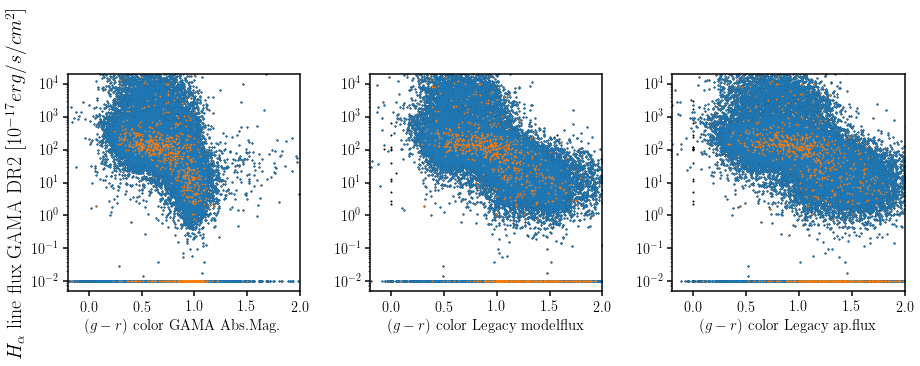

In [19]:
fig = plt.figure(figsize=(15, 4))
xs = [g_absmag_gama-r_absmag_gama, g_mag_legacy - r_mag_legacy, g_mag_legacy_apflux - r_mag_legacy_apflux]
xlbls = ['GAMA Abs.Mag.', 'Legacy modelflux', 'Legacy ap.flux']
for i, x, xlbl in zip(range(1,len(xs)+1), ys, ylbls):
    sub = fig.add_subplot(1, len(xs), i)
    hasha = (gama_ha > 0)
    sub.scatter(x[hasha], gama_ha[hasha], s=1, c='k', label='GAMA-Legacy')
    sub.scatter(x[np.invert(hasha)], np.repeat(1e-2, np.sum(np.invert(hasha))), s=1, c='k')
    sub.scatter(x[hasha & mag_cut], gama_ha[hasha & mag_cut], s=1, c='C0', label='MagCut')
    sub.scatter(x[np.invert(hasha) & mag_cut], np.repeat(1e-2, np.sum(np.invert(hasha) & mag_cut)), s=1, c='C0')
    sub.scatter(x[hasha & inblock & mag_cut], gama_ha[hasha & inblock & mag_cut], c='C1', s=0.5, label='Block MagCut')
    sub.scatter(x[np.invert(hasha) & inblock & mag_cut], 
                np.repeat(1e-2, np.sum(np.invert(hasha) & inblock & mag_cut)), c='C1', s=0.5, label='Block MagCut')
    sub.set_xlabel(r'$(g-r)$ color '+xlbl, fontsize=15)
    sub.set_xlim([-0.2, 2.])
    if i == 1: sub.set_ylabel(r'$H_\alpha$ line flux GAMA DR2 $[10^{-17}erg/s/cm^2]$', fontsize=20)
    sub.set_ylim([5e-3, 2e4])
    sub.set_yscale('log')
fig.subplots_adjust(wspace=0.3)

## Redshift Efficiency
Now lets take a look at the redshifts

(18, 25.5)

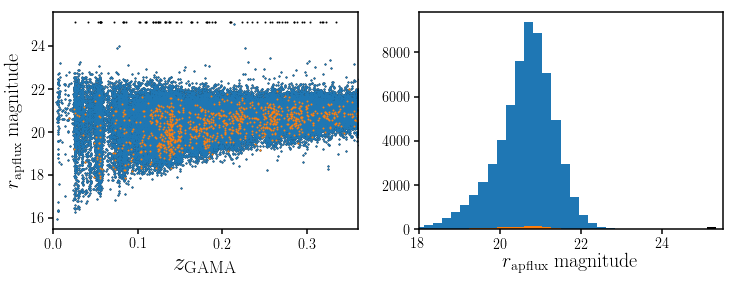

In [20]:
fig = plt.figure(figsize=(12,4))
sub1 = fig.add_subplot(121)
sub1.scatter(redshift, r_mag_legacy_apflux, s=1, c='k')
sub1.scatter(redshift[mag_cut], r_mag_legacy_apflux[mag_cut], s=1, c='C0')
sub1.scatter(redshift[inblock & mag_cut], r_mag_legacy_apflux[inblock & mag_cut], s=1, c='C1')
sub1.set_xlabel(r'$z_\mathrm{GAMA}$', fontsize=25)
sub1.set_xlim([0., 0.36])
sub1.set_ylabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub2 = fig.add_subplot(122)
_ = sub2.hist(r_mag_legacy_apflux, histtype='stepfilled', range=(17, 26), bins=40, color='k')
_ = sub2.hist(r_mag_legacy_apflux[mag_cut], histtype='stepfilled', range=(17, 26), bins=40, color='C0')
_ = sub2.hist(r_mag_legacy_apflux[inblock & mag_cut], histtype='stepfilled', range=(17, 26), bins=40, color='C1')
sub2.set_xlabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub2.set_xlim([18, 25.5])

Lets compare the redshift we measure from redrock to the "true" input redshift from GAMA. 

In [21]:
print('%i ZWARN > 0 with bright sky ' % np.sum(zbright_data['ZWARN'] > 0))
print('%i ZWARN > 0 with dark sky ' % np.sum(zdark_data['ZWARN'] > 0))

6 ZWARN > 0 with bright sky 
5 ZWARN > 0 with dark sky 


In [22]:
block_magcut = (r_mag_legacy_apflux[inblock] < 25.0)

In [23]:
print('%i ZWARN > 0 with bright sky ' % np.sum(zbright_data['ZWARN'][block_magcut] > 0))
print('%i ZWARN > 0 with dark sky ' % np.sum(zdark_data['ZWARN'][block_magcut] > 0))

4 ZWARN > 0 with bright sky 
3 ZWARN > 0 with dark sky 


(0.001, 1.0)

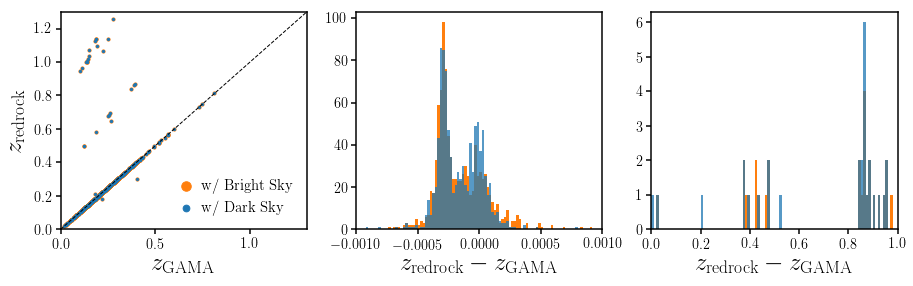

In [24]:
fig = plt.figure(figsize=(15,4))
sub = fig.add_subplot(131)
sub.scatter(redshift[inblock][block_magcut], zbright_data['Z'][block_magcut], #[np.arange(ngal)[inblock & mag_cut]], 
            c='C1', s=10, label='w/ Bright Sky')
sub.scatter(redshift[inblock][block_magcut], zbright_data['Z'][block_magcut], #[np.arange(ngal)[inblock & mag_cut]], 
            c='C0', s=5, label='w/ Dark Sky')
sub.plot([0., 10.], [0., 10.], c='k', lw=1, ls='--')
sub.set_xlabel(r"$z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0., 1.3])
sub.set_ylabel(r"$z_\mathrm{redrock}$", fontsize=25)
sub.set_ylim([0., 1.3])
sub.legend(loc='lower right', markerscale=3, handletextpad=0., prop={'size':15})
sub = fig.add_subplot(132)
_ = sub.hist(zbright_data['Z'][block_magcut] - redshift[inblock & mag_cut], color='C1', 
             range=(-0.001, 0.001), bins=100, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(zdark_data['Z'][block_magcut] - redshift[inblock & mag_cut], color='C0', 
             range=(-0.001, 0.001), bins=100, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlabel(r"$z_\mathrm{redrock} - z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([-0.001, 0.001])
sub = fig.add_subplot(133)
_ = sub.hist(zbright_data['Z'][block_magcut] - redshift[inblock & mag_cut], color='C1', 
             range=(0.001,1.), bins=100, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(zdark_data['Z'][block_magcut] - redshift[inblock & mag_cut], color='C0', 
             range=(0.001, 1), bins=100, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlabel(r"$z_\mathrm{redrock} - z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0.001, 1.0])

In [25]:
print('Dark Sky: %i galaxies have Delta z > 0.1' % np.sum(zbright_data['Z'][block_magcut] - redshift[inblock & mag_cut] > 0.1))
print('Bright Sky: %i galaxies have Delta z > 0.1' % np.sum(zdark_data['Z'][block_magcut] - redshift[inblock & mag_cut] > 0.1))

Dark Sky: 27 galaxies have Delta z > 0.1
Bright Sky: 26 galaxies have Delta z > 0.1


In [26]:
dz_1pz_dark = (zdark_data['Z'] - redshift[inblock])/(1.+redshift[inblock])
dz_1pz_bright = (zbright_data['Z'] - redshift[inblock])/(1.+redshift[inblock])

(0.75, 0.85)

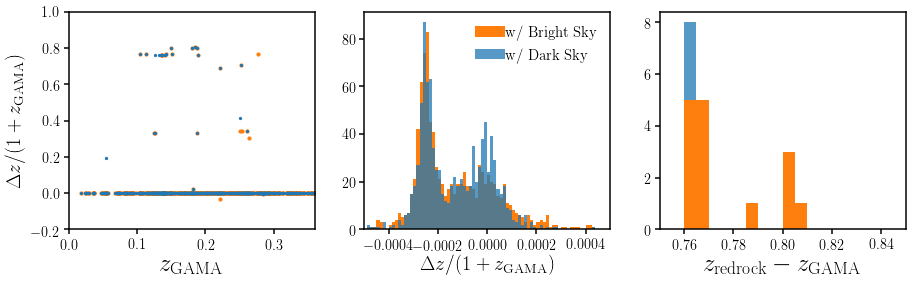

In [27]:
fig = plt.figure(figsize=(15,4))
sub = fig.add_subplot(131)
sub.scatter(z_gama[block_magcut], dz_1pz_bright[block_magcut], c='C1', s=10, label='w/ Bright Sky')
sub.scatter(z_gama[block_magcut], dz_1pz_dark[block_magcut], c='C0', s=5, label='w/ Dark Sky')
sub.set_xlabel(r"$z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0., 0.36])
sub.set_ylabel(r"$\Delta z / (1+z_\mathrm{GAMA})$", fontsize=20)
sub.set_ylim([-0.2, 1.])
sub = fig.add_subplot(132)
_ = sub.hist(dz_1pz_bright[block_magcut], color='C1', 
             range=(-0.00075, 0.0005), bins=100, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(dz_1pz_dark[block_magcut], color='C0', 
             range=(-0.00075, 0.0005), bins=100, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlabel(r"$\Delta z / (1+z_\mathrm{GAMA})$", fontsize=20)
sub.legend(loc='upper right', markerscale=3, handletextpad=0., prop={'size':15})
sub.set_xlim([-0.0005, 0.0005])
sub = fig.add_subplot(133)
_ = sub.hist(dz_1pz_dark[block_magcut], color='C0', 
             range=(0.75, 0.85), bins=20, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
_ = sub.hist(dz_1pz_bright[block_magcut], color='C1', 
             range=(0.75, 0.85), bins=20, histtype='stepfilled', label='w/ Bright Sky')
sub.set_xlabel(r"$z_\mathrm{redrock} - z_\mathrm{GAMA}$", fontsize=25)
sub.set_xlim([0.75, 0.85])

In [28]:
assert np.array_equal(redshift[inblock & mag_cut], redshift[inblock][block_magcut])

(0.0, 0.0002)

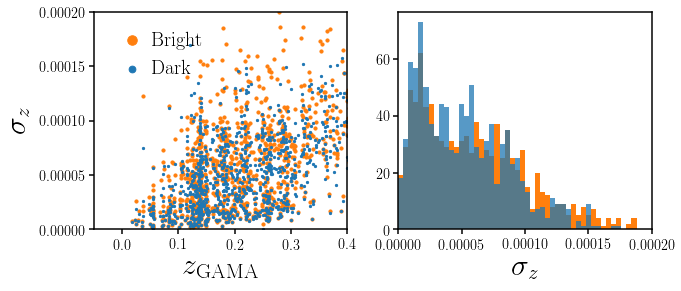

In [29]:
fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(121)
sub.scatter(redshift[inblock & mag_cut], zbright_data['ZERR'][block_magcut], c='C1', s=10, label='Bright')
sub.scatter(redshift[inblock & mag_cut], zdark_data['ZERR'][block_magcut], c='C0', s=5, label='Dark')
sub.set_xlabel(r"$z_\mathrm{GAMA}$", fontsize=30)
sub.set_xlim([-0.05, 0.4])
sub.set_ylabel(r"$\sigma_z$", fontsize=30)
sub.set_ylim([0, 2e-4])
sub.legend(loc='upper left', markerscale=3, handletextpad=0.0, prop={'size': 20})
sub = fig.add_subplot(122)
_ = sub.hist(zbright_data['ZERR'][block_magcut], color='C1', 
             range=(0., 0.0002), bins=50, histtype='stepfilled', label='w/ Bright Sky')
_ = sub.hist(zdark_data['ZERR'][block_magcut], color='C0', 
             range=(0., 0.0002), bins=50, histtype='stepfilled', alpha=0.75, label='w/ Dark Sky')
sub.set_xlabel(r"$\sigma_z$", fontsize=30)
sub.set_xlim([0., 0.0002])

Now lets see the redshift success rate (quantified as $\Delta z/(1+z) < 0.003$) as a function of various parameters. 

In [30]:
def gethist(var, ztrue, zbest, range=None, threshold=0.003):
    """ 
    """
    dz = zbest - ztrue
    dz_1pz = np.abs(dz)/(1.+ztrue)
    s1 = (dz_1pz < threshold)
    
    h0, bins = np.histogram(var, bins=30, range=range)
    hv, _ = np.histogram(var, bins=bins, weights=var)
    h1, _ = np.histogram(var[s1], bins=bins)
    
    good = h0 > 2
    hv = hv[good]
    h0 = h0[good]
    h1 = h1[good]

    vv = hv / h0 # weighted mean of var
    
    def _eff(k, n):
        eff = k.astype("float") / (n.astype('float') + (n==0))
        efferr = np.sqrt(eff * (1 - eff)) / np.sqrt(n.astype('float') + (n == 0))
        return eff, efferr
    
    e1, ee1 = _eff(h1, h0)

    return vv, e1, ee1

Lets see how `redrock` redshift success rate, defined as $\Delta z /(1+z) < 0.003$, changes as a function of various properties

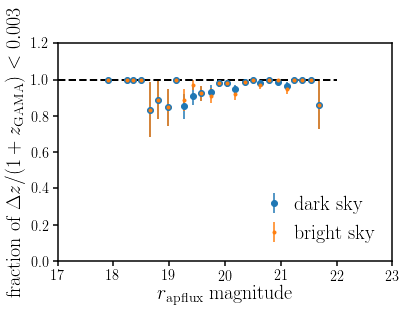

In [31]:
mm_dark, e1_dark, ee1_dark = gethist(r_mag_legacy_apflux[inblock & mag_cut], 
                                     redshift[inblock & mag_cut], zdark_data['Z'][block_magcut])
mm_bright, e1_bright, ee1_bright = gethist(r_mag_legacy_apflux[inblock & mag_cut], 
                                           redshift[inblock & mag_cut], zbright_data['Z'][block_magcut])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([17., 22.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub.set_xlim([17., 23.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', handletextpad=0., prop={'size': 20})

Text(0.5,1,'No $H\\alpha$ line flux')

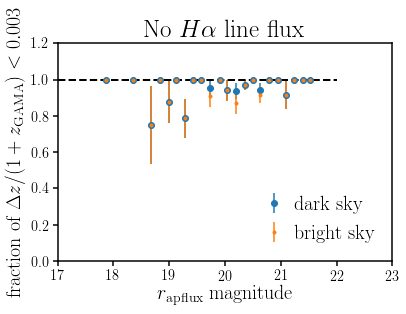

In [32]:
noha = (gama_ha < 0.)
mm_dark, e1_dark, ee1_dark = gethist(r_mag_legacy_apflux[inblock & noha], 
                                     redshift[inblock & noha], zdark_data['Z'][gama_ha[inblock] < 0.])
mm_bright, e1_bright, ee1_bright = gethist(r_mag_legacy_apflux[inblock & noha], 
                                           redshift[inblock & noha], zbright_data['Z'][gama_ha[inblock] < 0.])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([17., 22.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'$r_\mathrm{apflux}$ magnitude', fontsize=20)
sub.set_xlim([17., 23.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', handletextpad=0., prop={'size': 20})
sub.set_title(r'No $H\alpha$ line flux', fontsize=25)

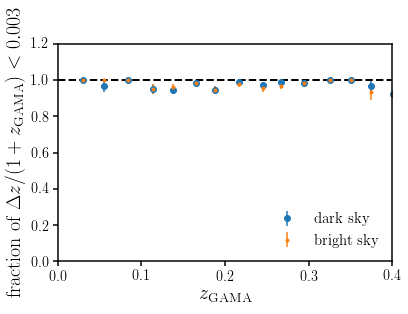

In [33]:
mm_dark, e1_dark, ee1_dark = gethist(redshift[inblock & mag_cut], 
                                     redshift[inblock & mag_cut], zdark_data['Z'][block_magcut])
mm_bright, e1_bright, ee1_bright = gethist(redshift[inblock & mag_cut], 
                                           redshift[inblock & mag_cut], zbright_data['Z'][block_magcut])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([0., 0.5], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'$z_\mathrm{GAMA}$', fontsize=20)
sub.set_xlim([0.0, 0.4])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', prop={'size': 15})

(0.0, 1.2)

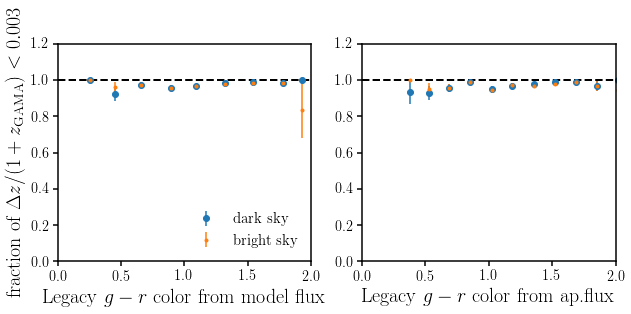

In [34]:
mm_dark, e1_dark, ee1_dark = gethist((g_mag_legacy - r_mag_legacy)[inblock & mag_cut], 
                                     redshift[inblock & mag_cut], zdark_data['Z'][block_magcut])
mm_bright, e1_bright, ee1_bright = gethist((g_mag_legacy - r_mag_legacy)[inblock & mag_cut], 
                                           redshift[inblock & mag_cut], zbright_data['Z'][block_magcut])

fig = plt.figure(figsize=(10,4))
sub = fig.add_subplot(121)
sub.plot([0., 2.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'Legacy $g-r$ color from model flux', fontsize=20)
sub.set_xlim([0., 2.])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', prop={'size': 15})

mm_dark, e1_dark, ee1_dark = gethist((g_mag_legacy_apflux - r_mag_legacy_apflux)[inblock & mag_cut], 
                                     redshift[inblock & mag_cut], zdark_data['Z'][block_magcut])
mm_bright, e1_bright, ee1_bright = gethist((g_mag_legacy_apflux - r_mag_legacy_apflux)[inblock & mag_cut], 
                                           redshift[inblock & mag_cut], zbright_data['Z'][block_magcut])
sub = fig.add_subplot(122)
sub.plot([0., 2.], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'Legacy $g-r$ color from ap.flux', fontsize=20)
sub.set_xlim([0., 2.])
sub.set_ylim([0., 1.2])


391


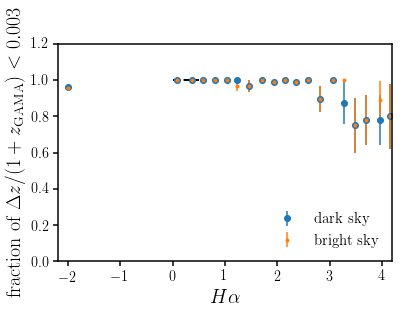

In [35]:
block_ha = gama_ha[inblock & mag_cut]
print(np.sum(block_ha < 0.))
block_ha[block_ha < 0.] = 1e-2
mm_dark, e1_dark, ee1_dark = gethist(np.log10(block_ha), 
                                     redshift[inblock & mag_cut], zdark_data['Z'][block_magcut])
mm_bright, e1_bright, ee1_bright = gethist(np.log10(block_ha),
                                           redshift[inblock & mag_cut], zbright_data['Z'][block_magcut])

fig = plt.figure()
sub = fig.add_subplot(111)
sub.plot([0., 0.5], [1., 1.], c='k', ls='--', lw=2)
sub.errorbar(mm_dark, e1_dark, ee1_dark, c='C0', fmt='o', label="dark sky")
sub.errorbar(mm_bright, e1_bright, ee1_bright, fmt='.C1', label="bright sky")
sub.set_xlabel(r'$H\alpha$', fontsize=20)
sub.set_xlim([-2.2, 4.2])
sub.set_ylabel(r'fraction of $\Delta z /(1+z_\mathrm{GAMA}) < 0.003$', fontsize=20)
sub.set_ylim([0., 1.2])
sub.legend(loc='lower right', prop={'size': 15})